## Import necessary packages

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.plotting import plot_anat

from dipy.denoise.localpca import mppca
import dipy.reconst.dti as dti
import dipy.core.gradients as dpg
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.segment.mask import median_otsu

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data overview

In [2]:
img_fraw = nib.load("../AA_041/AA_041_8_ep2d_diff_30_iso.nii.gz")

In [3]:
print(img_fraw.shape)

(112, 112, 60, 65)


In [4]:
print(img_fraw.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 57
dim             : [  4 112 112  60  65   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.9642857  1.9642857  2.5        9.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : alternating increasing 2
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=99;Time=161210.120;phase=1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.00096292916
quatern_c       : -0.9986472
quatern_d       : -0.

## Visualization of Diffusion Metrics

In [5]:
# Define the subject ID and DWI files
subject_id = "AA_041"
fraw = f"../{subject_id}/{subject_id}_8_ep2d_diff_30_iso.nii.gz"
fbval = f"../{subject_id}/{subject_id}_8_ep2d_diff_30_iso.bval"
fbvec = f"../{subject_id}/{subject_id}_8_ep2d_diff_30_iso.bvec"

In [6]:
# Load the DWI data
fraw_img = nib.load(fraw)
data = fraw_img.get_fdata()
affine = fraw_img.affine

In [8]:
# Load the b-values and b-vectors
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

### Attempt 1

In [9]:
# Create a mask to exclude background
mask = data[..., 0] > 0

In [10]:
# Prepare the gradient table
gtab = dpg.gradient_table(bvals, bvecs)

In [11]:
# Optional: Denoising using local principal component analysis (can be removed if not required)
data, sigma = mppca(data, patch_radius=[4, 4, 4], return_sigma=True)

In [12]:
# Fit the diffusion tensor model
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(data, mask=mask)

In [13]:
# Calculate FA, MD, AD, and RD
fa = dti_fit.fa
md = dti_fit.md
ad = dti_fit.ad
rd = dti_fit.rd

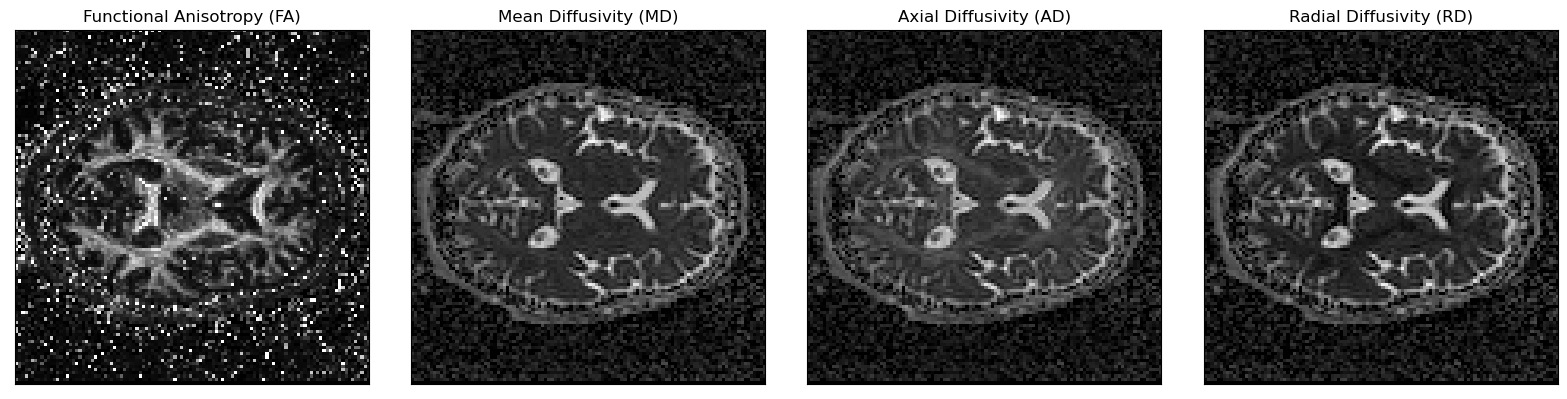

In [51]:
# Plot the diffusion metrics
fig1, ax = plt.subplots(1, 4, figsize=(16, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

# Plot Functional Anisotropy (FA)
ax.flat[0].imshow(fa[:, :, fa.shape[2] // 2], cmap="gray", origin="lower")
ax.flat[0].set_title("Functional Anisotropy (FA)")

# Plot Mean Diffusivity (MD)
ax.flat[1].imshow(md[:, :, md.shape[2] // 2], cmap="gray", origin="lower")
ax.flat[1].set_title("Mean Diffusivity (MD)")

# Plot Axial Diffusivity (AD)
ax.flat[2].imshow(ad[:, :, ad.shape[2] // 2], cmap="gray", origin="lower")
ax.flat[2].set_title("Axial Diffusivity (AD)")

# Plot Radial Diffusivity (RD)
ax.flat[3].imshow(rd[:, :, rd.shape[2] // 2], cmap="gray", origin="lower")
ax.flat[3].set_title("Radial Diffusivity (RD)")

plt.tight_layout()
plt.show()

### Attempt 100 :p

- steve hanson - head of RUBIC - check his articles
- smith as well - founder of FSL - check parameters
- check conn toolbox
- smooth colored image more

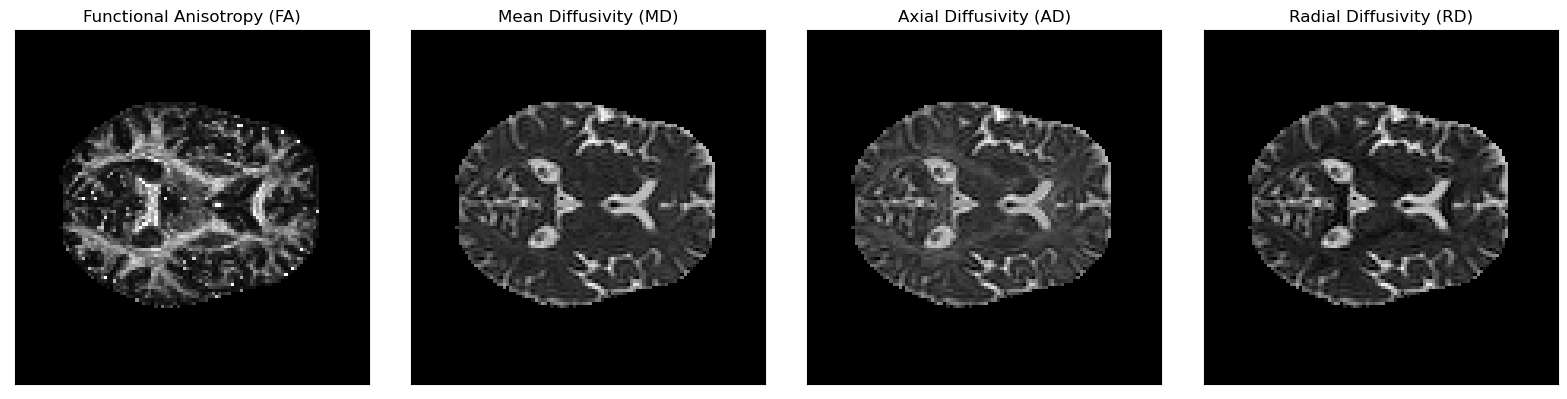

In [61]:
# Create a binary mask to exclude background using median otsu thresholding
# Select volumes [0, 1] for thresholding, apply median filtering with radius 4, perform 2 iterations
# Disable autocropping and perform binary dilation
maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=False, dilate=1)

# Select a specific axial slice from the mask
axial_slice = 30
mask_ss = np.zeros(mask.shape)
mask_ss[:, :, axial_slice] = mask[:, :, axial_slice]

# Prepare the gradient table using the loaded b-values and b-vectors
gtab = dpg.gradient_table(bvals, bvecs)

# Optional: Perform local principal component analysis denoising with patch radius [4, 4, 4]
# Return the denoised data and estimated noise standard deviation
data, sigma = mppca(data, patch_radius=[4, 4, 4], return_sigma=True) # This step can be removed if not needed

# Fit the diffusion tensor model to the data, considering only the selected axial slice
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(data, mask=mask_ss)

# Calculate diffusion metrics: Functional Anisotropy (FA), Mean Diffusivity (MD),
# Axial Diffusivity (AD), and Radial Diffusivity (RD)
fa = dti_fit.fa
md = dti_fit.md
ad = dti_fit.ad
rd = dti_fit.rd

# Plot the diffusion metrics using subplots
fig1, ax = plt.subplots(1, 4, figsize=(16, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

# Plot Functional Anisotropy (FA) on the selected axial slice
ax.flat[0].imshow(fa[:, :, axial_slice], cmap="gray", origin="lower")
ax.flat[0].set_title("Functional Anisotropy (FA)")

# Plot Mean Diffusivity (MD) on the selected axial slice
ax.flat[1].imshow(md[:, :, axial_slice], cmap="gray", origin="lower")
ax.flat[1].set_title("Mean Diffusivity (MD)")

# Plot Axial Diffusivity (AD) on the selected axial slice
ax.flat[2].imshow(ad[:, :, axial_slice], cmap="gray", origin="lower")
ax.flat[2].set_title("Axial Diffusivity (AD)")

# Plot Radial Diffusivity (RD) on the selected axial slice
ax.flat[3].imshow(rd[:, :, axial_slice], cmap="gray", origin="lower")
ax.flat[3].set_title("Radial Diffusivity (RD)")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Color Coded FA map

Dipy can also be used to produce a colour coded FA maps. In addition of indicating the anisotropy degree by the colour level intensity, these maps provide the information of the main direction of the diffusion tensor according to the following colour coding standard:

red indicates that diffusion is higher on right-left directions

green indicates that diffusion is higher on anterior-posterior directions

blue indicates that diffusion is higher on inferior-superior directions

The information about the main direction of the diffusion tensor can be retrieved from the diffusion tensor eigenvectors which is saved in "dti_fit" attribute "evecs". The colour coded FA map is produced in the following way:

Text(0.5, 1.0, 'Color coded FA')

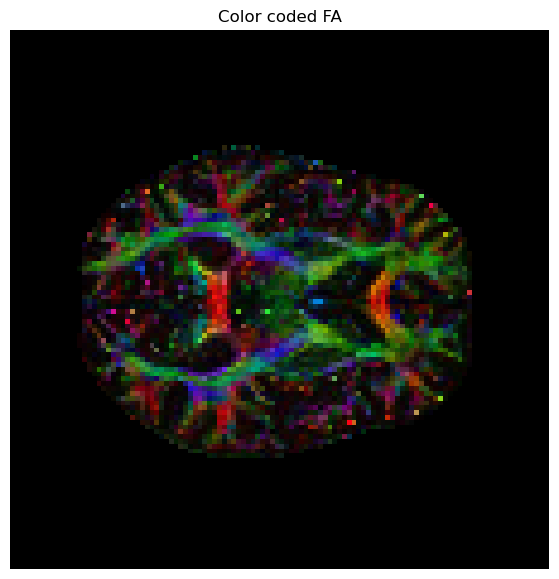

In [71]:
fa = np.clip(fa, 0, 1)  # Just to ensure that FA values are between 0 and 1
colored_fa = dti.color_fa(fa, dti_fit.evecs)

plt.figure(figsize=(9, 7))
plt.subplot(1, 1, 1).set_axis_off()
plt.imshow(colored_fa[:, :, axial_slice])
plt.title("Color coded FA")